In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [302]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [303]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import src.features.build_features as FeaturesManager

In [310]:
seasons_year = [2015, 2016, 2017, 2018]
features_data = FeaturesManager.build_features(seasons_year)
features_data.sample(10)

,Game ID,Event Index,Time,Period,Team,Type,Shot Type,Shooter,Goalie,Empty Net,Strength,X,Y,st_X,st_Y,Distance to Net,Relative Angle
63708,2018021007,172,10:53,2,Arizona Coyotes (ARI),SHOT,Backhand,Josh Archibald,Jimmy Howard,NaN,NaN,-55.0,33.0,55.0,-33.0,47.381431,44.144903
24702,2017020386,6,00:20,1,Calgary Flames (CGY),SHOT,Backhand,Matt Stajan,Scott Wedgewood,NaN,NaN,-73.0,-3.0,73.0,3.0,16.278821,10.619655
62954,2015021048,131,05:55,2,Philadelphia Flyers (PHI),SHOT,Wrist Shot,Sean Couturier,Scott Darling,NaN,NaN,-84.0,-12.0,84.0,12.0,13.000000,67.380135
15339,2016020254,295,19:41,3,Edmonton Oilers (EDM),SHOT,Backhand,Jordan Eberle,Peter Budaj,NaN,NaN,84.0,10.0,84.0,10.0,11.180340,63.434949
50736,2017020789,325,19:47,3,Carolina Hurricanes (CAR),SHOT,Slap Shot,Justin Williams,Petr Mrazek,NaN,NaN,-60.0,-12.0,60.0,12.0,31.384710,22.479434
23981,2017020373,331,13:27,3,Chicago Blackhawks (CHI),SHOT,Wrist Shot,Nick Schmaltz,Pekka Rinne,NaN,NaN,-83.0,-1.0,83.0,1.0,6.082763,9.462322
32491,2018020513,157,18:15,2,Columbus Blue Jackets (CBJ),SHOT,Wrist Shot,Riley Nash,Malcolm Subban,NaN,NaN,-55.0,16.0,55.0,-16.0,37.576588,25.201124
33598,2017020525,117,01:17,2,Vegas Golden Knights (VGK),SHOT,Slap Shot,William Karlsson,Andrei Vasilevskiy,NaN,NaN,69.0,2.0,NaN,NaN,NaN,NaN
53755,2018020852,294,07:44,3,Nashville Predators (NSH),SHOT,Wrist Shot,P.K. Subban,Jake Allen,NaN,NaN,38.0,-25.0,38.0,-25.0,56.797887,26.113913
53703,2015020895,208,04:32,3,Toronto Maple Leafs (TOR),SHOT,Snap Shot,Mark Arcobello,Carter Hutton,NaN,NaN,-44.0,26.0,44.0,-26.0,51.971146,30.018367


In [312]:
distance_data = features_data[['Shot distance', 'Is Goal']].dropna()
X = distance_data['Shot distance'].to_numpy().reshape(-1, 1)
y = distance_data['Is Goal'].to_numpy().reshape(-1, 1)

In [313]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [314]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [315]:
accuracy = clf.score(X_valid, y_valid)
print(f'Accuracy on validation set = {np.around(100.*accuracy, 2)}%')

Accuracy on validation set = 90.54%


0.9053815471130583
Dumb Accuracy on validation set = 90.54%


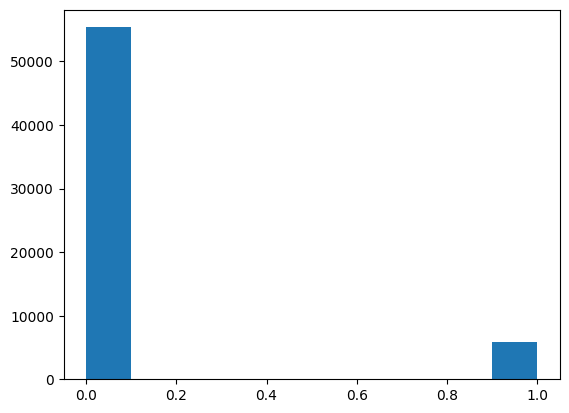

In [317]:
# Accuracy is not the right metric to use, as the classes are unbalanced
num_goals = (y_valid==1).sum()
num_no_goals = (y_valid==0).sum()
print(num_no_goals / (num_no_goals+num_goals))
plt.hist(y_valid);

# A dumb model that predicts 0 (no goals) all the time reach the same level of performance
def dumb_model(X, y):
    pred = np.zeros_like(X)
    return (y == pred).mean()


dumb_accuracy = dumb_model(X_valid, y_valid)
print(f'Dumb Accuracy on validation set = {np.around(100.*dumb_accuracy, 2)}%')

In [318]:
y_proba = clf.predict_proba(X_valid)
y_proba_no_goals = y_proba[:,0]
y_proba_goals = y_proba[:,1]

In [319]:
fpr, tpr, _ = roc_curve(y_valid, y_proba_goals)
roc_auc = auc(fpr, tpr)

fpr, tpr, _ = roc_curve(y_valid.ravel(), y_proba_goals.ravel())
roc_auc = auc(fpr, tpr)

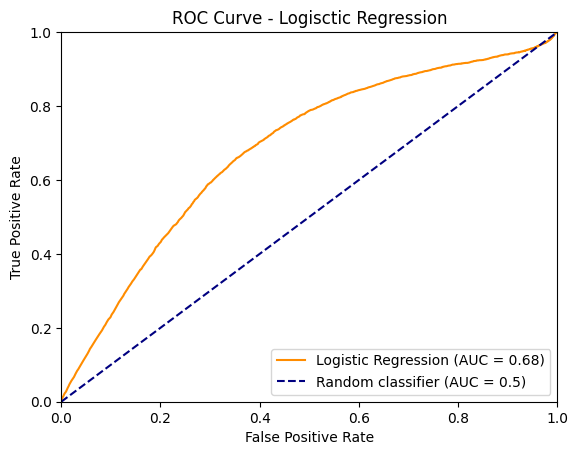

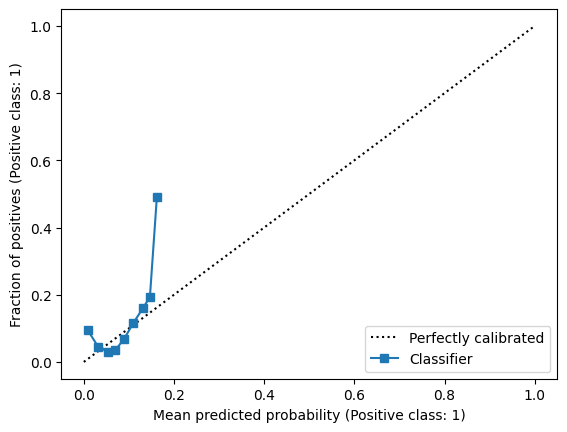

In [320]:
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="Logistic Regression (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", label='Random classifier (AUC = 0.5)', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logisctic Regression")
plt.legend(loc="lower right")
plt.show()

disp = CalibrationDisplay.from_predictions(y_valid, y_proba_goals, n_bins=50)

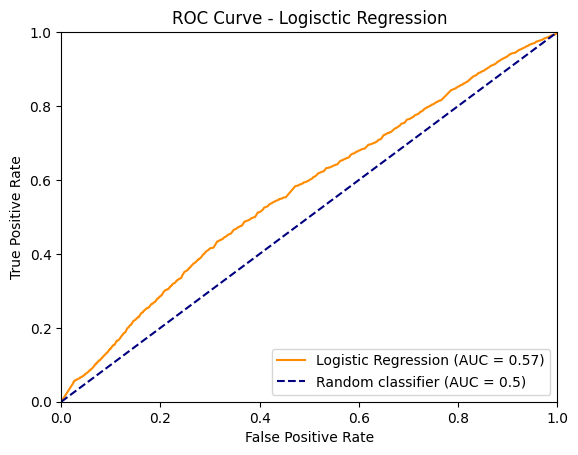

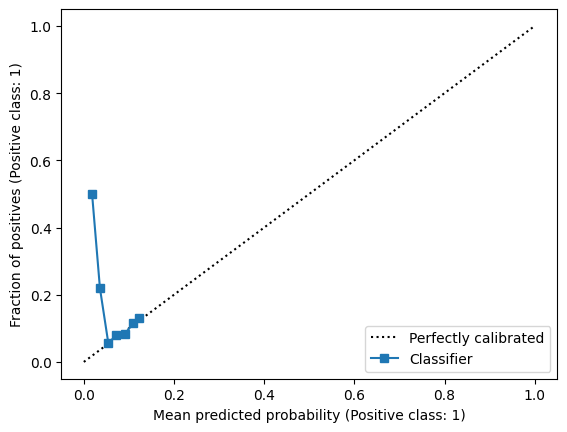

In [326]:
angle_data = features_data[['Shot angle', 'Is Goal']].dropna()
X = angle_data['Shot angle'].to_numpy().reshape(-1, 1)
y = angle_data['Is Goal'].to_numpy().reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_proba = clf.predict_proba(X_valid)
y_proba_no_goals = y_proba[:,0]
y_proba_goals = y_proba[:,1]

fpr, tpr, _ = roc_curve(y_valid, y_proba_goals)
roc_auc = auc(fpr, tpr)
fpr, tpr, _ = roc_curve(y_valid.ravel(), y_proba_goals.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="Logistic Regression (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", label='Random classifier (AUC = 0.5)', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logisctic Regression")
plt.legend(loc="lower right")
plt.show()

disp = CalibrationDisplay.from_predictions(y_valid, y_proba_goals, n_bins=50)

In [327]:
distance_angle_data = features_data[['Shot distance', 'Shot angle', 'IsGoal']].dropna()
X = distance_angle_data[['Shot distance', 'Shot angle']].to_numpy()
y = distance_angle_data['Is Goal'].to_numpy().reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_proba = clf.predict_proba(X_valid)
y_proba_no_goals = y_proba[:,0]
y_proba_goals = y_proba[:,1]

fpr, tpr, _ = roc_curve(y_valid, y_proba_goals)
roc_auc = auc(fpr, tpr)
fpr, tpr, _ = roc_curve(y_valid.ravel(), y_proba_goals.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="Logistic Regression (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", label='Random classifier (AUC = 0.5)', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logisctic Regression")
plt.legend(loc="lower right")
plt.show()

disp = CalibrationDisplay.from_predictions(y_valid, y_proba_goals, n_bins=50)

KeyError: "['IsGoal'] not in index"

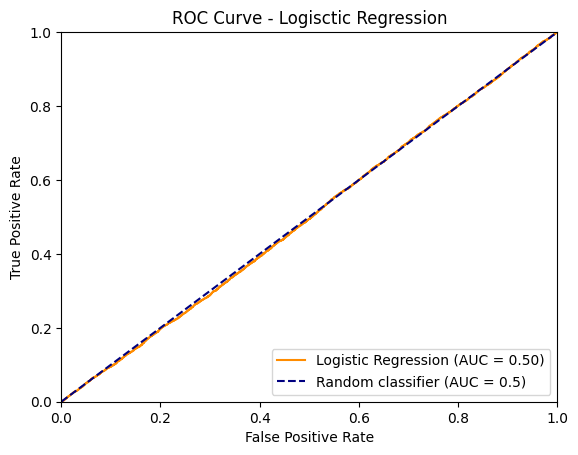

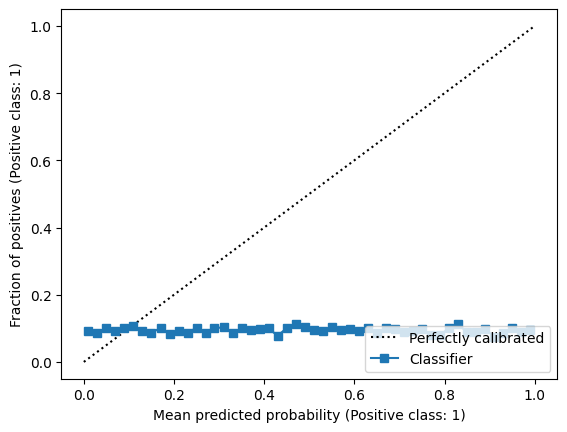

In [328]:
distance_angle_data = features_data[['Shot distance', 'Shot angle', 'Is Goal']].dropna()
X = distance_angle_data[['Shot distance', 'Shot angle']].to_numpy()
y = distance_angle_data['Is Goal'].to_numpy().reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


y_proba = np.random.uniform(low=0.0, high=1.0, size=len(y_valid))
y_proba_no_goals = y_proba
y_proba_goals = 1 - y_proba

fpr, tpr, _ = roc_curve(y_valid, y_proba_goals)
roc_auc = auc(fpr, tpr)
fpr, tpr, _ = roc_curve(y_valid.ravel(), y_proba_goals.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="Logistic Regression (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", label='Random classifier (AUC = 0.5)', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logisctic Regression")
plt.legend(loc="lower right")
plt.show()

disp = CalibrationDisplay.from_predictions(y_valid, y_proba_goals, n_bins=50)